# Setup (run this, no need to read)

## General imports

In [ ]:
import pandas as pd
import numpy as np
from copy import deepcopy
import random
import seaborn as sns
import re
%pip install adjustText
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
!pip install matplotlib-label-lines
import labellines
import plotly.express as px

In [ ]:
from datetime import datetime
date = datetime.today().strftime('%Y-%m-%d')

In [ ]:
from scipy.optimize import minimize, minimize_scalar
from scipy.stats import norm
from sklearn.metrics import r2_score

import json
from google.colab import files

In [ ]:
np.seterr(over='ignore') # models 14 and 15

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

## Data

In [ ]:
# load primary algorithmic progress dataset
path = "https://docs.google.com/spreadsheets/d/11m8O_mU0cUkOB_5wluPne4PNsuvsKNbbVAzbYNy-NXY/edit#gid=91564213"
path = path.replace("edit#", "export?") + "&format=csv"
df = pd.read_csv(path, parse_dates=True)

# remove unnecessary columns
columns_to_remove = ['Author(s)', 'Link', 'Hardware', 'Base Model', 'GitHub', 'Comments', 'Organizations', 'Organization Categorization', 'Comments']
df = df.drop(columns=columns_to_remove)

# rename columns
column_renames = {
    'Publication date': 'publication_date',
    'Parameters': 'param',
    'Perplexity (WT103)': 'ppl_wt103',
    'Perplexity (WT2)': 'ppl_wt2',
    'Perplexity (PTB)': 'ppl_ptb',
    'Dataset Size': 'dataset',
    'System': 'system',
    'Epoch': 'epoch',
    'Include?': 'include',
    'Zero-shot?': 'zero_shot',
    'Citations': 'cites',
    'Peer reviewed?': 'peer_reviewed',
    'Outlier?': 'outlier'
}
df = df.rename(columns=column_renames)

# convert publication date to datetime format
def convert_to_fraction_of_year(date):
    return date.year + (date.dayofyear - 1) / 365.0
df['publication_date'] = pd.to_datetime(df['publication_date'], format='%Y/%m/%d', errors='coerce')
df['publication_date'] = df['publication_date'].apply(convert_to_fraction_of_year)

# convert param and data to numeric values
df['param'] = pd.to_numeric(df['param'], errors='coerce')
df['dataset'] = pd.to_numeric(df['dataset'], errors='coerce')

# drop rows when 0 or NaN
df.dropna(subset=['param', 'dataset'], inplace=True)
df = df.loc[(df['param'] > 0) & (df['dataset'] > 0)]
df = df.loc[(df['include'] != 0)]
df = df.loc[(df['outlier'] != 1)]

df.dropna(subset=['ppl_wt103', 'ppl_wt2', 'ppl_ptb'], how='all', inplace=True)
df.reset_index(drop=True, inplace=True) # reset the index of the dataframe after dropping rows

# perplexity data
df['ppl'] = df['ppl_wt103'].fillna(df['ppl_wt2']).fillna(df['ppl_ptb']) # single ppl column

def safe_log(column): # modified logarithm for handling possible zero values
    return np.where(column != 0, np.log(column), np.nan)
for col in ['param', 'dataset', 'ppl_wt103', 'ppl_wt2', 'ppl_ptb', 'ppl']:
    df[f'log_{col}'] = safe_log(df[col])

Prepare data for algorithmic progress analysis. This is where we exclude models where the data is particularly uncertain or are clear outliers.

In [ ]:
# filter models and form new df
df_wt103 = df.dropna(subset=['log_ppl_wt103'])
df_wt2 = df.dropna(subset=['log_ppl_wt2'])
df_ptb = df.dropna(subset=['log_ppl_ptb'])
df1 = pd.concat([
    df_wt103.assign(dataset_name='wt103'),
    df_wt2.assign(dataset_name='wt2'),
    df_ptb.assign(dataset_name='ptb')
])
len_before_filter = len(df1)

# name systems based on dataset
df1['system_dataset'] = df1['system'].str.cat(df1['dataset_name'], sep='_')
df1['dataset_name'] = df1['dataset_name'].astype('category') # convert to categorical
dataset_idx = df1['dataset_name'].cat.codes.values

# create dummies for benchmarks
df1['ptb_dummy'] = (df1['dataset_name'] == 'ptb').astype(int)
df1['wt2_dummy'] = (df1['dataset_name'] == 'wt2').astype(int)

# drop models
df1= df1[(df1['uncertain']==0)]
columns_to_check = ['log_param', 'log_dataset', 'publication_date', 'ppl']
df1 = df1[~df1[columns_to_check].replace([np.inf, -np.inf], np.nan).isnull().any(axis=1)]

# sort by reference and ppl
df1 = df1.sort_values(['Reference', 'ppl'], ascending=[True, True])

In [ ]:
mask = df1['system'] == "GPT3-6.7B + muP"
index_to_drop = df1[mask].index
df1 = df1.drop(index_to_drop)

mask = df1['system'] == "LLaMA-65B (LoRA finetuned)"
index_to_drop = df1[mask].index
df1 = df1.drop(index_to_drop)

mask = df1['system'] == "LLaMA-13B (LoRA finetuned)"
index_to_drop = df1[mask].index
df1 = df1.drop(index_to_drop)


mask = df1['system'] == "LLaMA-7B (LoRA finetuned)"
index_to_drop = df1[mask].index
df1 = df1.drop(index_to_drop)

# Print original 'param' values for 'Gopher (280B)' and 'Gopher (7.1B)'
print("Original 'param' values:")
print("Gopher (280B):", df1.loc[df1['system'] == 'Gopher (280B)', 'param'].values)
print("Gopher (7.1B):", df1.loc[df1['system'] == 'Gopher (7.1B)', 'param'].values)

# Apply the changes
df1.loc[df1['system'] == 'Gopher (280B)', 'param'] = 280e9
df1.loc[df1['system'] == 'Gopher (7.1B)', 'param'] = 7.1e9

# Print updated 'param' values for 'Gopher (280B)' and 'Gopher (7.1B)'
print("\nUpdated 'param' values:")
print("Gopher (280B):", df1.loc[df1['system'] == 'Gopher (280B)', 'param'].values)
print("Gopher (7.1B):", df1.loc[df1['system'] == 'Gopher (7.1B)', 'param'].values)

Original 'param' values:
Gopher (280B): [2.8e+11]
Gopher (7.1B): [7.1e+09]

Updated 'param' values:
Gopher (280B): [2.8e+11]
Gopher (7.1B): [7.1e+09]


# Software progress across domains (section 1)

## Setup

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.transforms import Affine2D
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

In [ ]:
# Data
data = {
    "Domain": ["Large language models", "SAT\nSolvers", "Mathematical Programming Solvers", "Mathematical Programming Solvers", "Mathematical Programming Solvers", "Computer Vision", "Computer Vision ", "Deep RL", "Deep RL", "Deep RL", "Stockfish (Computer chess)", "Avg of 57\ntextbook algorithms"],
    "Sub-problem": ["", "", "Linear\nPrograms", "Mixed Integer\nLinear\nPrograms", "Linear\nPrograms", "Computer\nVision", "Computer\nVision ", "Atari\n(Deep RL)", "State-based\ncontrol\n(Deep RL)", "Pixel-based\ncontrol\n(Deep RL)", "Stockfish (Computer chess)", "Avg of 57\ntextbook algorithms"],
    "Doubling time central estimate": ["999 months","24 months", "76 months", "30 months", "17 months", "9 months", "15 months", "10 to 18 months", "5 to 24 months", "4 to 9 months", "15 months", "9 months"],
    "Doubling time 5th percentile": [np.nan,np.nan, np.nan, np.nan, np.nan, 4, np.nan, np.nan, np.nan, np.nan, np.nan, 5],
    "Doubling time 95th percentile": [np.nan,np.nan, np.nan, np.nan, np.nan, 25, np.nan, np.nan, np.nan, np.nan, np.nan, 27]
}
references = ["", "Fichte et al.,\n2020", "Koch et al.,\n2022", "Koch et al.,\n2022", "Bixby, 2002", "Erdil and\nBesiroglu,\n2022", "Hernandez\nand Brown,\n2020", "Dorner,\n2021", "Dorner,\n2021", "Dorner,\n2021", "Erdil and Besiroglu,\n2024", ""]

data = {
    "Domain": ["Large language models", "SAT\nSolvers", "Mathematical Programming Solvers", "Mathematical Programming Solvers", "Computer Vision", "Computer Vision ", "Deep RL", "Deep RL", "Deep RL", "Stockfish (Computer chess)", "Avg of 57\ntextbook algorithms"],
    "Sub-problem": ["", "", "Linear\nPrograms", "Linear\nPrograms", "Computer\nVision", "Computer\nVision ", "Atari\n(Deep RL)", "State-based\ncontrol\n(Deep RL)", "Pixel-based\ncontrol\n(Deep RL)", "Stockfish (Computer chess)", "Avg of 57\ntextbook algorithms"],
    "Doubling time central estimate": ["999 months","24 months", "30 to 76 months", "17 months", "9 months", "15 months", "10 to 18 months", "5 to 24 months", "4 to 9 months", "15 months", "9 months"],
    "Doubling time 5th percentile": [np.nan,np.nan, np.nan, np.nan, 4, np.nan, np.nan, np.nan, np.nan, np.nan, 5],
    "Doubling time 95th percentile": [np.nan,np.nan, np.nan, np.nan, 25, np.nan, np.nan, np.nan, np.nan, np.nan, 27]
}
references = ["", "Fichte et al.,\n2020", "Koch et al.,\n2022", "Bixby, 2002", "Erdil and\nBesiroglu,\n2022", "Hernandez\nand Brown,\n2020", "Dorner,\n2021", "Dorner,\n2021", "Dorner,\n2021", "Erdil and\nBesiroglu,\n2024", ""]


# DataFrame
df = pd.DataFrame(data)
df['Reference'] = references

# Preprocessing
def extract_estimate(value):
    if value.strip() == "":
        return np.nan
    value = value.split(' ')[0]
    return float(value.split(' to ')[0]) if 'to' in str(value) else float(value)

def extract_max_estimate(value):
    if 'to' not in value:
        return np.nan
    return float(value.split(' to ')[-1].split(' ')[0])

def calculate_median_estimate(min_estimate, max_estimate):
    if np.isnan(min_estimate) and np.isnan(max_estimate):
        return np.nan
    if np.isnan(max_estimate):
        return min_estimate
    elif np.isnan(min_estimate):
        return max_estimate / 2
    elif np.isnan(max_estimate):
        return min_estimate / 2
    else:
        return (min_estimate + max_estimate) / 2

df['Min Estimate'] = df['Doubling time central estimate'].apply(extract_estimate)
df['Max Estimate'] = df['Doubling time central estimate'].apply(extract_max_estimate)
df['Median Estimate'] = df.apply(lambda row: calculate_median_estimate(row['Min Estimate'], row['Max Estimate']), axis=1)

# Splitting labels
def split_label(label, max_length=15):
    words = label.split()
    lines = []
    current_line = ""
    for word in words:
        if len(current_line) + len(word) <= max_length:
            current_line += word + " "
        else:
            lines.append(current_line.strip())
            current_line = word + " "
    lines.append(current_line.strip())
    return '\n'.join(lines)
df['X_label'] = df.apply(lambda row: row['Sub-problem'] if row['Sub-problem'].strip() != "" else row['Domain'], axis=1)
df['X_label'] = df['X_label'].apply(split_label)

# Filtering the rows with NaN values in 'Min Estimate' column
df_filtered = df.dropna(subset=['Min Estimate'])
df_filtered = df.dropna(subset=['Min Estimate']).sort_values(by='Min Estimate', ascending=False)

def doubling_time_to_growth_rate(doubling_time):
    return (2 ** (1 / (doubling_time/12)) - 1) * 100

df_filtered.loc[df_filtered['Min Estimate'] == 76.0, 'Median Estimate'] = 76.0

df_filtered.loc[df_filtered['Reference'] == "Erdil and\nBesiroglu,\n2022", 'Median Estimate'] = 9.0

In [ ]:
import requests
import pandas as pd
from io import StringIO
import numpy as np

ci = 95

doubling_time_list = [0.5914202888473794,1.0415970696898855,0.8681474262794402,0.552725067142858,0.7152000844250258,0.8494553879728164,0.881268970723509,0.7789063581282941,0.5944588856952477,0.41475836451478915,0.6741792406481362,0.5559199915864789,0.6079570771424813,0.7548532579558166,0.6631608792281272,1.062440167285672,0.8676817599516954,0.41958594840795654,0.7529751851259957,0.9847462033929717,0.7514181314398858,0.8407362900337253,0.9017516263204252,0.8725539051397965,0.8298952971971618,0.409544534249351,0.808876387056506,0.649001197907251,0.9406405343220183,0.6914561888397939,0.3366604215362794,0.6249432265981731,0.700997087280605,0.788969870190672,0.47101818357098135,0.6164463208070722,0.7807886016155882,0.37998846047566376,0.5197962366574556,0.7602339411709775,0.6081365054597744,0.6041934119797461,0.5452819566135938,0.6954506274824329,0.9754720701809453,0.7596317445433091,0.4567783381397205,0.4952885307322248,0.6987694544192452,0.8852813967760522,0.36385817974272994,0.40465495236953286,0.38260769971417247,0.57124275941847,0.9393913162242744,0.7757974828705102,0.7666669400210622,0.3780256339203352,0.8222127416461988,0.7763293131126349,0.5065418080289411,0.9182385652561246,2.4384563165415916,0.6322201555623442,0.7908233385215367,0.9510403588863034,0.41932177968596385,0.456201042680464,0.62358439150487,0.4989864332483955,0.7007985513544648,1.0297641304759393,0.7986860609461585,0.6805064333565543,0.687259639099626,0.7933923936632623,0.7522275768124841,0.9625291618069859,9.923031664170043,0.5175787120009308,0.6547470167750121,0.5226635935273583,0.6748667868189113,0.7561062211110019,0.4154552910225829,0.9862751353221567,0.723812268100735,0.8154675874643124,0.38653326418286366,0.7757910133221634,0.7850895741846454,0.7133926187894883,0.6355210874173323,1.3340082731787832,0.8751814344602437,0.6289783379542582,0.7493028634787491,1.0298593717819247,0.6704083929356727,0.8814936293188184]
aggregated_compute_doubling_array = np.array(doubling_time_list)

# Assuming 'aggregated_compute_doubling_array' is your initial array
# Multiply by 12
samples = aggregated_compute_doubling_array * 12

# Calculate the 5th and 95th percentiles
percentile_5 = np.percentile(samples, (100-ci)/2)
percentile_95 = np.percentile(samples, 100- (100-ci)/2)

# Filter out the values outside the 5th and 95th percentiles
filtered_samples = samples[(samples >= percentile_5) & (samples <= percentile_95)]

In [ ]:
from matplotlib.ticker import FuncFormatter
# Function to format the log scale labels as integers
def format_func(value, tick_number):
    return f"{int(value)}"

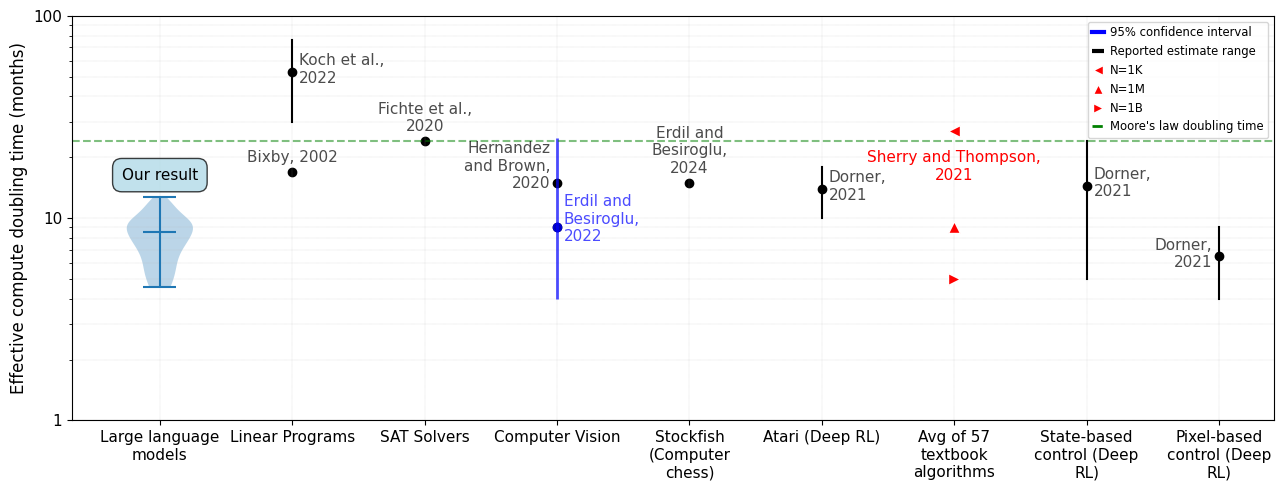

In [ ]:
special_y_adjust_default = 5  # Initial y-adjustment
previous_y_pos = []  # To keep track of y-positions

font_size=11
y_adjust = 1  # Initial y-adjustment
# Initialize horizontal alignment

# Plotting
fig, ax = plt.subplots(figsize=(13, 5))

for idx, row in df_filtered.iterrows():

    special_y_adjust = special_y_adjust_default
    horizontal_alignment = 'center'

    x_label = row['X_label']
    y_pos = row['Median Estimate']

    # Initialize x_offset to a default value
    x_offset = 0

    # Check for the specific reference and assign a unique offset
    if row['Reference'] == "Erdil and\nBesiroglu,\n2022":
        x_offset = 5  # Or whatever unique offset you want for this reference
        horizontal_alignment = 'left'  # Align left for non-zero x_offset

    # If it's not the specific reference, then check for 'Max Estimate'
    if row['Reference'] == "Dorner,\n2021":
        x_offset = 5  # Or another value that you decide is appropriate for entries with a 'Max Estimate'
        horizontal_alignment = 'left'  # Align left for non-zero x_offset

    # Check for the specific reference and assign a unique offset
    if row['Reference'] == "Koch et al.,\n2022":
        x_offset = 5  # Or whatever unique offset you want for this reference
        horizontal_alignment = 'left'  # Align left for non-zero x_offset

    # Check for the specific reference and assign a unique offset
    if row['Sub-problem'] == "Pixel-based\ncontrol\n(Deep RL)":
        x_offset = -5  # Or whatever unique offset you want for this reference
        horizontal_alignment = 'right'  # Align left for non-zero x_offset

    # Adjust y position for specific reference
    if row['Reference'] == "Hernandez\nand Brown,\n2020":
        x_offset = -5  # Or whatever unique offset you want for this reference
        horizontal_alignment = 'right'  # Align left for non-zero x_offset
        special_y_adjust = -6

    # Adjust y position for specific reference
    if row['Reference'] == "Erdil and\nBesiroglu,\n2022":
        special_y_adjust = -12

    # Adjust y position for specific reference
    if row['Reference'] == "Koch et al.,\n2022":
        special_y_adjust = -10

    # Adjust y position for specific reference
    if row['Reference'] == "Dorner,\n2021":
        special_y_adjust = -10

    # Customize marker and color based on the row
    marker_style = '' if 'Avg' in x_label else 'o'
    color_scheme = 'red' if 'Avg' in x_label else 'black'
    reference_color = 'blue' if row['Reference'] == "Erdil and\nBesiroglu,\n2022" else 'black'

    # Plot scatter and annotate
    ax.scatter([x_label], [y_pos], color=color_scheme, marker=marker_style)
    ax.annotate(row['Reference'],
                xy=(x_label, y_pos),
                xytext=(x_offset, special_y_adjust),  # Offset position by x_offset points to the right
                textcoords='offset points',  # This tells Matplotlib that xytext is an offset in points from the xy value
                fontsize=font_size,
                alpha=0.7,
                color=reference_color,
                ha=horizontal_alignment,  # Use the horizontal_alignment variable
                va='bottom')

    # Check if y_pos is too close to previous y-positions and adjust
    while any(abs(prev - y_pos) < y_adjust for prev in previous_y_pos):
        y_pos += y_adjust
    previous_y_pos.append(y_pos)

    # Additional plotting for max estimate and error bars
    if not np.isnan(row['Max Estimate']):
        ax.plot([x_label, x_label], [row['Min Estimate'], row['Max Estimate']], color='black')

    if not np.isnan(row['Doubling time 5th percentile']) and not np.isnan(row['Doubling time 95th percentile']) and 'Avg' not in x_label:
        yerr_lower = row['Min Estimate'] - row['Doubling time 5th percentile']
        yerr_upper = row['Doubling time 95th percentile'] - row['Min Estimate']
        ax.errorbar([x_label], [row['Min Estimate']], yerr=[[yerr_lower], [yerr_upper]], color='blue', fmt='o', linewidth=2, alpha=0.7)

    if not np.isnan(row['Doubling time 5th percentile']) and not np.isnan(row['Doubling time 95th percentile']) and row['Doubling time 5th percentile'] == 5 and 'Avg' not in x_label:
        y_lower = row['Min Estimate'] - row['Doubling time 5th percentile']
        y_upper = row['Min Estimate'] + row['Doubling time 95th percentile']

        ax.scatter([x_label], [y_lower], color='red', marker='>')
        ax.scatter([x_label], [y_upper], color='red', marker='<')

        if not np.isnan(row['Max Estimate']):
            yerr_lower_max = row['Max Estimate'] - row['Doubling time 5th percentile']
            yerr_upper_max = row['Doubling time 95th percentile'] - row['Max Estimate']

            y_lower_max = row['Max Estimate'] - yerr_lower_max
            y_upper_max = row['Max Estimate'] + yerr_upper_max

            ax.scatter([x_label], [y_lower_max], color='red', marker='<')
            ax.scatter([x_label], [y_upper_max], color='red', marker='>')

ax.axhline(y=24, color='g', linestyle='--', alpha=0.5)

# Create a secondary y-axis for the annual growth rates
#sec_ax = ax.twinx()
#sec_ax.set_ylabel('Annual growth rate', fontsize=12)

# Manually set primary y-axis (doubling time) ticks
primary_yticks = [8]
ax.set_yticks(primary_yticks)
#secondary_ytick_labels = [f'{doubling_time_to_growth_rate(tick):.1f}%' for tick in primary_yticks]
#sec_ax.set_yticks(primary_yticks)
#sec_ax.set_yticklabels(secondary_ytick_labels)  # Reverse if needed
plt.xticks(rotation=0, fontsize=7)

# Set primary y-axis label
ax.set_ylabel('Effective compute doubling time (months)', fontsize=12)

# Legend and custom elements
# Legend
# Define custom legend items
legend_elements = [
    Line2D([0], [0], color='blue', lw=3, label='95% confidence interval'),
    Line2D([0], [0], color='black', lw=3, label='Reported estimate range', linestyle='dashed'),
    Line2D([0], [0], marker='<', color='w', markerfacecolor='red', markersize=7, label='N=1K', linestyle='None'),
    Line2D([0], [0], marker='^', color='w', markerfacecolor='red', markersize=7, label='N=1M', linestyle='None'),
    Line2D([0], [0], marker='>', color='w', markerfacecolor='red', markersize=7, label='N=1B', linestyle='None'),
    Line2D([0], [0], color='g', linestyle='--', lw=2, label="Moore's law doubling time")
]

# Get x position of third label
x_pos = list(ax.get_xticks())[6]

# Create marker handles with offsets
marker1 = Line2D(np.array([x_pos]), np.array([27]), marker='<', color='w', markerfacecolor='red', markersize=8, linestyle='None')
marker2 = Line2D(np.array([x_pos]), np.array([9]), marker='^', color='w', markerfacecolor='red', markersize=8, linestyle='None')
marker3 = Line2D(np.array([x_pos]), np.array([5]), marker='>', color='w', markerfacecolor='red', markersize=8, linestyle='None')

# Add to axes
ax.add_artist(marker1)
ax.add_artist(marker2)
ax.add_artist(marker3)

# Convert the left-most x-label to a numeric position for the violin plot
# This step depends on how your x-axis is set up
x_labels = df_filtered['X_label'].unique().tolist()

# Add the violin plot at the left-most x-value's numeric position
ax.violinplot(filtered_samples, positions=[0], widths=0.5, showmeans=False, showmedians=True)

ax.text(x_pos, 15, 'Sherry and Thompson,\n2021', fontsize=font_size, color='red', ha='center', va='bottom')

ax.text(0, 15, 'Our result',
        fontsize=11,
        ha='center',
        va='bottom',
        bbox=dict(facecolor='lightblue', alpha=0.75, boxstyle='round,pad=0.6'))

ax.set_yscale('log')

plt.ylim(1,100)
ax.set_ylim(1, 100)

# Apply the custom formatter to the y-axis
ax.yaxis.set_major_formatter(FuncFormatter(format_func))

# Add legend with custom patches
ax.legend(handles=legend_elements, loc='upper right', ncol=1, handlelength=1, handletextpad=0.5, fontsize='small')

# Grid, ticks, labels, and layout
ax.grid(which='both', linestyle='--', linewidth=0.15)
plt.xticks(rotation=0, fontsize=11)
plt.yticks(rotation=0, fontsize=11)
plt.title('')
plt.tight_layout()
plt.savefig('doubling_time.png')
plt.show()

# Log perplexity over time (section 2)

In [ ]:
# filter models and form new df
df2 = pd.concat([
    df_wt103.assign(dataset_name='wt103'),
    df_wt2.assign(dataset_name='wt2'),
])

df2_unique = df2.drop_duplicates(subset='system')

/usr/local/lib/python3.10/dist-packages/matplotlib/collections.py:963: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
/usr/local/lib/python3.10/dist-packages/matplotlib/collections.py:963: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


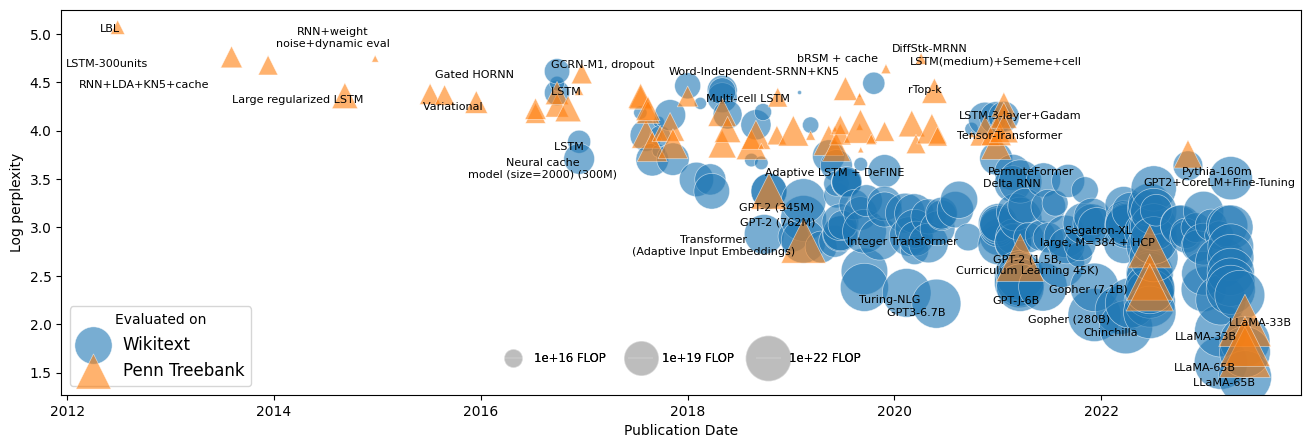

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from adjustText import adjust_text
from scipy.spatial import KDTree

# Assuming df2_unique and df_ptb are pre-defined DataFrames

# Function to process the dataframes
def process_dataframe(df):
    df['neg_log_ppl'] = np.log(df['ppl'])
    df = df.sort_values('publication_date')

    df['system'] = df['system'].apply(
        lambda x: x.split('(')[0]
        if not any(char in x.split('(')[-1] for char in ['m', 'M', 'B'])
        else x
    )

    df['epoch'] = pd.to_numeric(df['epoch'], errors='coerce').fillna(1)
    df['inferred_compute'] = 6 * df['dataset'] * df['param'] * df['epoch']
    df = df.dropna(subset=['inferred_compute'])
    df = df[df['inferred_compute'] > 1e13]
    df['log_inferred_compute'] = np.log10(df['inferred_compute'])
    return df

# Process both dataframes
df2_unique_processed = process_dataframe(df2_unique)
df_ptb_processed = process_dataframe(df_ptb)

# Plotting setup
fig, ax = plt.subplots(figsize=(16, 5))

# Plot df2_unique
scatter1 = ax.scatter(df2_unique_processed['publication_date'], df2_unique_processed['neg_log_ppl'],
                      s=(df2_unique_processed['log_inferred_compute'] - 14) * 150,
                      alpha=0.6, edgecolors='w', linewidth=0.5, label='Wikitext')

# Plot df_ptb
scatter2 = ax.scatter(df_ptb_processed['publication_date'], df_ptb_processed['neg_log_ppl'],
                      s=(df_ptb_processed['log_inferred_compute'] - 14) * 150,
                      alpha=0.6, edgecolors='w', linewidth=0.5, label='Penn Treebank', marker='^')

# Dynamic labeling
points_combined = np.vstack([
    np.array(list(zip(df2_unique_processed['publication_date'], df2_unique_processed['neg_log_ppl']))),
    np.array(list(zip(df_ptb_processed['publication_date'], df_ptb_processed['neg_log_ppl'])))
])
tree = KDTree(points_combined)

min_distance = 0.175  # Adjust as needed
texts = []
for i, point in enumerate(points_combined):
    distances, _ = tree.query(point, k=2)
    if distances[1] > min_distance:
        label = (df2_unique_processed.iloc[i]['system'] if i < len(df2_unique_processed) else df_ptb_processed.iloc[i - len(df2_unique_processed)]['system'])
        if len(label) > 25:
            midpoint = len(label) // 2
            split_point = label[:midpoint].rfind(' ') + 1
            label = label[:split_point].strip() + '\n' + label[split_point:].strip()
        texts.append(ax.text(point[0], point[1], label, fontsize=8))

adjust_text(texts)

# Finalizing the plot
ax.set_xlabel('Publication Date')
ax.set_ylabel('Log perplexity')
ax.grid(False)

# Prepare the first legend for datasets
first_legend_labels = ['Wikitext', 'Penn Treebank']
first_legend = ax.legend(first_legend_labels, title='Evaluated on', fontsize='large', loc='lower left', scatterpoints=1)

# Dummy scatter points for compute size legend
sizes = [1e16, 1e19, 1e22]  # Example compute sizes
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=f'{compute:.0e} FLOP',
                              markerfacecolor='gray', markersize=np.sqrt((np.log10(compute) - 14.8) * 150),
                              alpha=0.3) for compute in sizes]

# Second legend for compute sizes, positioned slightly higher
compute_legend = ax.legend(handles=legend_elements, title='', fontsize='small', loc='lower center', ncol=3, frameon=False,
                           bbox_to_anchor=(0.5, 0.05))

# Add both legends to the axes
ax.add_artist(first_legend)
ax.add_artist(compute_legend)

# Save and display the plot
plt.savefig("combined_data.pdf", format='pdf', bbox_inches='tight')
plt.show()